In [99]:
# Imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import MobileNetV2, mobilenet_v2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [100]:
fish_dir = 'Fish_Dataset' 

path = []
label = []


for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if filename.endswith('.png') and 'GT' not in dir_name:
            
            folder_name = dir_name.split(os.sep)[-1]
            
            label.append(folder_name)
            path.append(os.path.join(dir_name, filename))


data = pd.DataFrame({'path': path, 'label': label})

In [101]:
#Train Test Split 
x_train, x_test = train_test_split(data, test_size=0.2, random_state=30, stratify=data['label'])
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30, stratify=x_train['label'])

In [102]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (5760, 2)
Shape of test data (1800, 2)
Shape of validation data (1440, 2)


In [103]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

In [104]:
# Define the labels in sorted order
labels = ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel',
          'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp',
          'Striped Red Mullet', 'Trout']
unique_labels = sorted(set(labels))

In [105]:
#Keras Image generator for preprocessing towards model 
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = ImageDataGenerator(rescale=1./255)

train_images = train_generator.flow_from_dataframe(dataframe=x_train, x_col='path', y_col='label', target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='rgb', class_mode='categorical', batch_size=BATCH_SIZE, shuffle=True, class_names=unique_labels)

val_images = train_generator.flow_from_dataframe(dataframe=x_val, x_col='path', y_col='label', target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='rgb', class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False, class_names=unique_labels)
test_images = train_generator.flow_from_dataframe(dataframe=x_test, x_col='path', y_col='label', target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='rgb', class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False, class_names=unique_labels)

Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


In [106]:
#Importing pretrained model : MobileNetV2

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [107]:
#Create model inputs
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,439,625 (9.31 MB)

 Trainable params: 181,641 (709.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [108]:
Epochs = 10

save_path = f"saved_models/MobileNetV2.keras"

In [109]:
from tensorflow.keras.callbacks import ModelCheckpoint
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath=save_path,         # Path to save the model
    monitor='val_loss',         # Metric to monitor
    save_best_only=True,        # Save only the best model
    mode='min',                 # Save when 'val_loss' is minimized
    verbose=1                   # Print information about saving
)

history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=Epochs,
                    callbacks=[checkpoint_callback])

c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 967ms/step - accuracy: 0.8438 - loss: 0.5221
Epoch 1: val_loss improved from inf to 0.02823, saving model to saved_models/MobileNetV2.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.8444 - loss: 0.5202 - val_accuracy: 0.9910 - val_loss: 0.0282
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9991 - loss: 0.0094
Epoch 2: val_loss improved from 0.02823 to 0.01595, saving model to saved_models/MobileNetV2.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.9991 - loss: 0.0094 - val_accuracy: 0.9965 - val_loss: 0.0160
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9991 - loss: 0.0064
Epoch 3: val_loss improved from 0.01595 to 0.00435, saving model to saved_models/MobileNetV2.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.9991 - loss: 0.0063 - val_accuracy: 0.9986 - val_loss: 0.0043
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - accuracy: 1.0000 - loss: 9.7110e-04
Epo

In [110]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

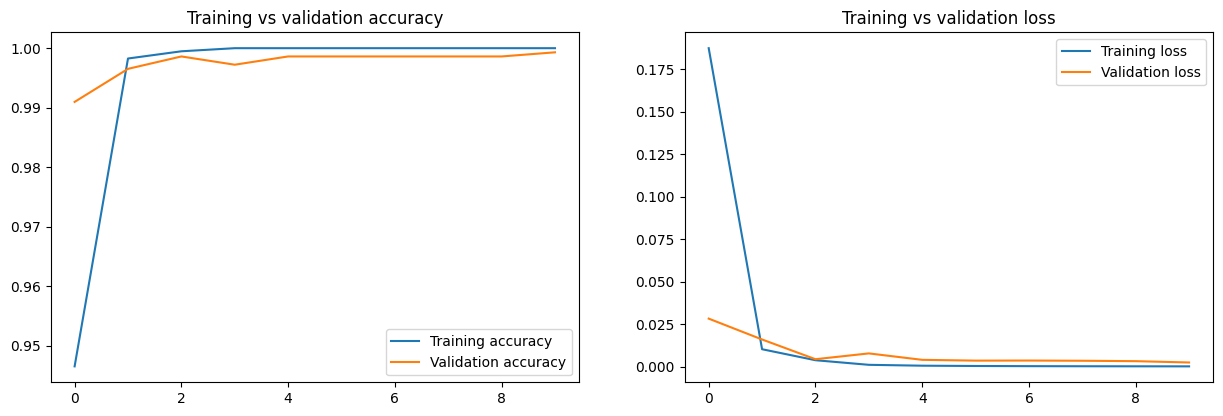

In [111]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

In [112]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model(save_path)

# # Optionally, print the model's summary to verify the structure
# model.summary()

In [116]:
results = model.evaluate(test_images)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 336ms/step - accuracy: 0.9972 - loss: 0.0088
Test Loss: 0.00472
Test Accuracy: 99.89%


57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step


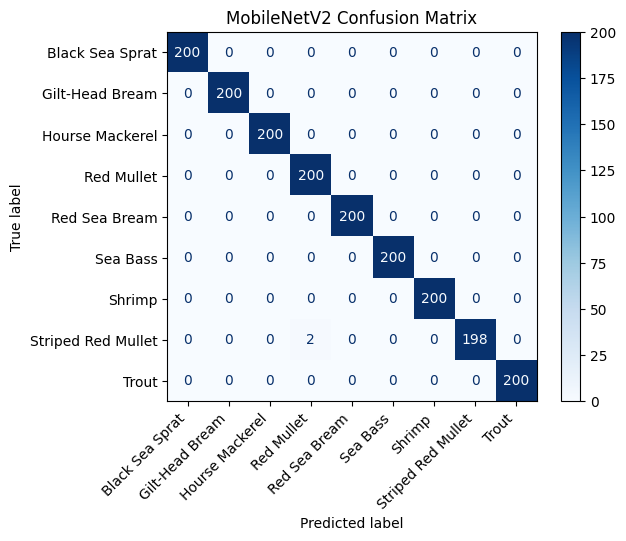


Classification Report:
                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       200
   Gilt-Head Bream       1.00      1.00      1.00       200
   Hourse Mackerel       1.00      1.00      1.00       200
        Red Mullet       0.99      1.00      1.00       200
     Red Sea Bream       1.00      1.00      1.00       200
          Sea Bass       1.00      1.00      1.00       200
            Shrimp       1.00      1.00      1.00       200
Striped Red Mullet       1.00      0.99      0.99       200
             Trout       1.00      1.00      1.00       200

          accuracy                           1.00      1800
         macro avg       1.00      1.00      1.00      1800
      weighted avg       1.00      1.00      1.00      1800



In [117]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Get predictions from the model
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)  # Convert the one-hot encoded predictions to class indices

# Get the true labels from the test generator
true_labels = test_images.labels

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(test_images.class_indices.keys()))
disp.plot(cmap='Blues', values_format='d')  # Customize the color map and format for values
plt.title("MobileNetV2 Confusion Matrix")  # Add a title
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

# Generate classification report
class_report = classification_report(true_labels, pred, target_names=list(test_images.class_indices.keys()))

# Print the classification report
print("\nClassification Report:")
print(class_report)

In [115]:
# Training and validation accuracy of the saved model
min_val_loss_index = val_loss.index(min(val_loss))

min_val_loss = val_loss[min_val_loss_index]
corresponding_accuracy = accuracy[min_val_loss_index]
corresponding_val_accuracy = val_accuracy[min_val_loss_index]

print(f"Minimum Validation Loss: {min_val_loss}")
print(f"Training Accuracy at Min Val Loss: {corresponding_accuracy}")
print(f"Validation Accuracy at Min Val Loss: {corresponding_val_accuracy}")


Minimum Validation Loss: 0.0024233441799879074
Training Accuracy at Min Val Loss: 1.0
Validation Accuracy at Min Val Loss: 0.9993055462837219
